In [0]:
# Imports here
import torch
import PIL
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torchvision import datasets, transforms, models
from torch import nn
from torch import optim
from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [0]:
#the data is stored in google drive so importing it......
#converting the wav to spectrograms ref https://www.kaggle.com/eatmygoose/cnn-detection-of-wheezes-and-crackles
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!ls "/content/drive/My Drive"

In [0]:
!cp "/content/drive/My Drive/Data.zip" "Data.zip"

In [0]:
!unzip Data.zip

Archive:  Data.zip
   creating: Data/
   creating: Data/test/
   creating: Data/test/C/
   creating: Data/test/CW/
  inflating: Data/test/CW/0.png      
  inflating: Data/test/CW/1.png      
  inflating: Data/test/CW/10.png     
  inflating: Data/test/CW/100.png    
  inflating: Data/test/CW/101.png    
  inflating: Data/test/CW/102.png    
  inflating: Data/test/CW/103.png    
  inflating: Data/test/CW/104.png    
  inflating: Data/test/CW/105.png    
  inflating: Data/test/CW/106.png    
  inflating: Data/test/CW/107.png    
  inflating: Data/test/CW/108.png    
  inflating: Data/test/CW/109.png    
  inflating: Data/test/CW/11.png     
  inflating: Data/test/CW/110.png    
  inflating: Data/test/CW/111.png    
  inflating: Data/test/CW/112.png    
  inflating: Data/test/CW/113.png    
  inflating: Data/test/CW/114.png    
  inflating: Data/test/CW/115.png    
  inflating: Data/test/CW/116.png    
  inflating: Data/test/CW/117.png    
  inflating: Data/test/CW/118.png    
  inflating

In [0]:
data_dir = 'Data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

In [0]:
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=75, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=75)
testloader = torch.utils.data.DataLoader(test_data, batch_size=75)

In [0]:
#using vgg16_bn 
model = models.vgg16_bn(pretrained=True)
model.name = "vgg16_bn"
model

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:09<00:00, 60.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
#not changing the predefined paraments in vgg_bn model
for param in model.parameters():
    param.requires_grad = False

In [0]:
#adding the classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 4, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [0]:
model.to(device);

In [0]:
#selecting the loss criterion, optimizer and number of epochs
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 10
print_every = 30
steps = 0

In [0]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    
    for ii, (inputs, labels) in enumerate(testloader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [0]:
print("Training process initializing .....\n")

for e in range(epochs):
    running_loss = 0
    model.train() # Technically not necessary, setting this for good measure
    
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model.eval()

            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print("Epoch: {}/{} | ".format(e+1, epochs),
                  "Training Loss: {:.4f} | ".format(running_loss/print_every),
                  "Validation Loss: {:.4f} | ".format(valid_loss/len(validloader)),
                  "Validation Accuracy: {:.4f}".format(accuracy/len(validloader)))
            
            running_loss = 0
            model.train()

print("\nTraining process is now complete!!")

Training process initializing .....

Epoch: 1/10 |  Training Loss: 2.3002 |  Validation Loss: 1.3116 |  Validation Accuracy: 0.3574
Epoch: 1/10 |  Training Loss: 1.2663 |  Validation Loss: 1.1238 |  Validation Accuracy: 0.5133
Epoch: 1/10 |  Training Loss: 1.1493 |  Validation Loss: 0.9983 |  Validation Accuracy: 0.5706
Epoch: 1/10 |  Training Loss: 1.0452 |  Validation Loss: 0.9319 |  Validation Accuracy: 0.5646
Epoch: 2/10 |  Training Loss: 0.1051 |  Validation Loss: 0.9049 |  Validation Accuracy: 0.5789
Epoch: 2/10 |  Training Loss: 0.7727 |  Validation Loss: 0.8295 |  Validation Accuracy: 0.5698
Epoch: 2/10 |  Training Loss: 0.7533 |  Validation Loss: 0.7525 |  Validation Accuracy: 0.6574
Epoch: 2/10 |  Training Loss: 0.7139 |  Validation Loss: 0.6985 |  Validation Accuracy: 0.6483
Epoch: 2/10 |  Training Loss: 0.6815 |  Validation Loss: 0.6986 |  Validation Accuracy: 0.6530
Epoch: 3/10 |  Training Loss: 0.1369 |  Validation Loss: 0.6706 |  Validation Accuracy: 0.6794
Epoch: 3/10 |

In [0]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) 
        correct += (predicted == labels).sum().item()

print('Accuracy achieved by the network on test images is: %f%%' % (100 * correct / total))

Accuracy achieved by the network on test images is: 75.306833%


In [0]:
model.class_to_idx = train_data.class_to_idx

In [0]:
checkpoint = {'architecture': model.name,
             'classifier': model.classifier,
             'class_to_idx': model.class_to_idx,
             'state_dict': model.state_dict()}

torch.save(checkpoint, 'vgg.pkl')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist

In [0]:
#download the trained model
from google.colab import files
files.download('vgg.pkl') 

In [0]:
def load_checkpoint():
    """
    Loads deep learning model checkpoint.
    """
    
    # Load the saved file
    checkpoint = torch.load("vgg16_bn.pth")
    
    # Download pretrained model
    model = models.vgg16_bn(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model


In [0]:
m1=load_checkpoint()

In [0]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    test_image = PIL.Image.open(image)

    # Get original dimensions
    orig_width, orig_height = test_image.size

    # Find shorter size and create settings to crop shortest side to 256
    if orig_width < orig_height: resize_size=[256, 256**600]
    else: resize_size=[256**600, 256]
        
    test_image.thumbnail(size=resize_size)

    # Find pixels to crop on to create 224x224 image
    center = orig_width/4, orig_height/4
    left, top, right, bottom = center[0]-(244/2), center[1]-(244/2), center[0]+(244/2), center[1]+(244/2)
    test_image = test_image.crop((left, top, right, bottom))

    # Converrt to numpy - 244x244 image w/ 3 channels (RGB)
    np_image = np.array(test_image)/255 # Divided by 255 because imshow() expects integers (0:1)!!

    # Normalize each color channel
    normalise_means = [0.485, 0.456, 0.406]
    normalise_std = [0.229, 0.224, 0.225]
    np_image = (np_image-normalise_means)/normalise_std
        
    # Set the color to the first channel
    np_image = np_image.transpose(2, 0, 1)
    
    return np_image

In [0]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

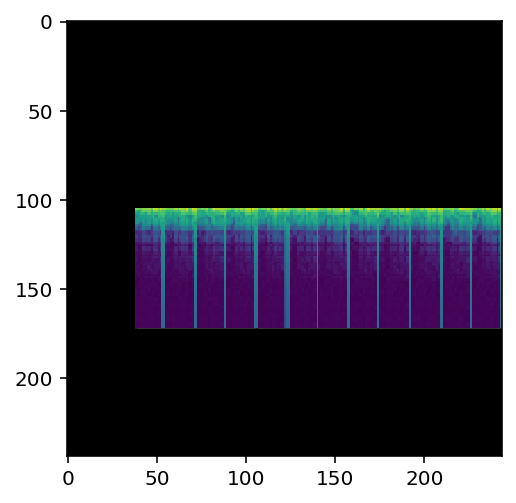

In [0]:
imshow(process_image("Data/validation/N/795.png"));

In [0]:
def predict(image_path, model, top_k=4):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    
    image_path: string. Path to image, directly to image and not to folder.
    model: pytorch neural network.
    top_k: integer. The top K classes to be calculated
    
    returns top_probabilities(k), top_labels
    '''
    
    # No need for GPU on this part (just causes problems)
    model.to("cpu")
    
    # Set model to evaluate
    model.eval();

    # Convert image from numpy to torch
    torch_image = torch.from_numpy(np.expand_dims(process_image(image_path), 
                                                  axis=0)).type(torch.FloatTensor).to("cpu")

    # Find probabilities (results) by passing through the function (note the log softmax means that its on a log scale)
    log_probs = model.forward(torch_image)

    # Convert to linear scale
    linear_probs = torch.exp(log_probs)

    # Find the top 5 results
    top_probs, top_labels = linear_probs.topk(top_k)
    
    # Detatch all of the details
    top_probs = np.array(top_probs.detach())[0] # This is not the correct way to do it but the correct way isnt working thanks to cpu/gpu issues so I don't care.
    top_labels = np.array(top_labels.detach())[0]
    
    # Convert to classes
    idx_to_class = {val: key for key, val in    
                                      model.class_to_idx.items()}
    top_labels = [lab for lab in top_labels]
    top_flowers = [lab for lab in top_labels]
    
    return top_probs, top_labels, top_flowers

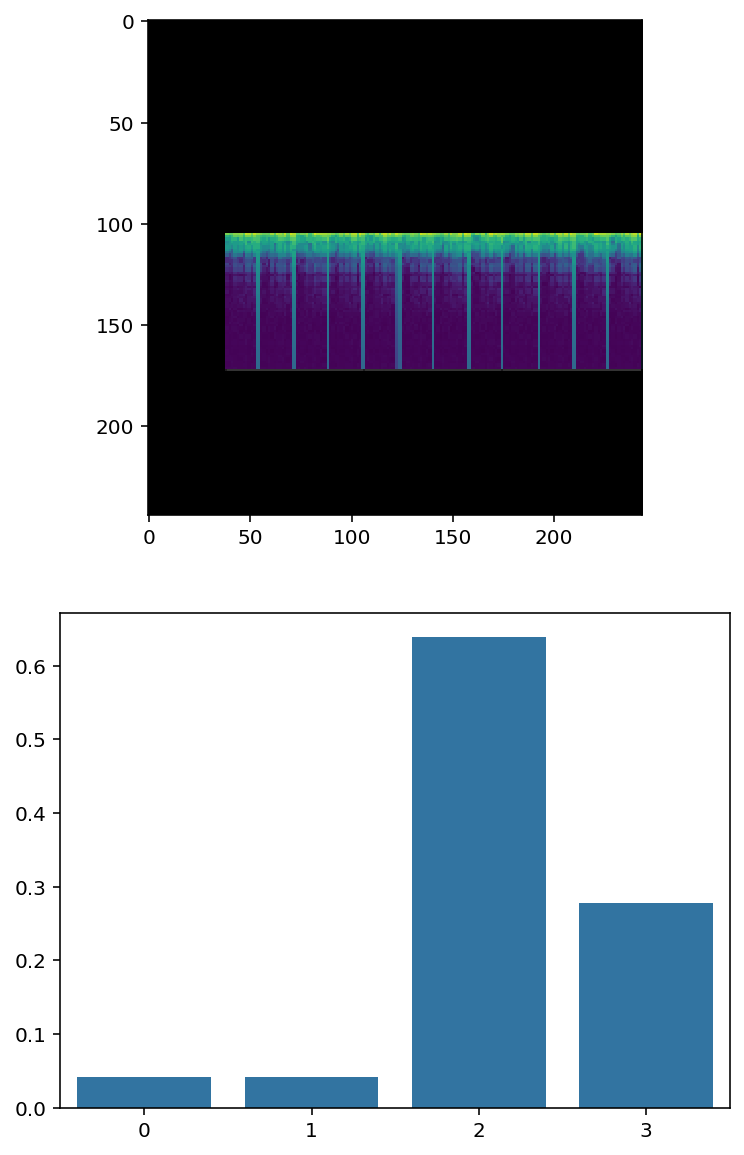

In [0]:
image_path = "Data/validation/N/795.png"

# Set up plot
plt.figure(figsize = (6,10))
ax = plt.subplot(2,1,1)


# Plot flower
img = process_image(image_path)
imshow(img, ax);

# Make prediction
probs, labs, flowers = predict(image_path, model) 

# Plot bar chart
plt.subplot(2,1,2)
sns.barplot(x=flowers, y=probs, color=sns.color_palette()[0]);
plt.show()